In [1]:
%load_ext autoreload
%autoreload 2

In [67]:
import os
import glob
import re
import itertools
import time
import joblib
import random

import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = 15
pd.options.display.max_colwidth = -1
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score, auc, roc_curve, make_scorer
from sklearn import svm, ensemble, datasets
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


In [3]:
import parsl
parsl.clear()

from polyfuse.configs.local import config
from polyfuse.configs.igsb_jupyter import config
parsl.load(config)

from polyfuse import apps, transformations

In [4]:
out_dir = '/cephfs/users/annawoodard/polyfuse/data/sim_50/processed'
model_dir = '/cephfs/users/annawoodard/polyfuse/data/sim_50/processed/models'
training_fraction = 0.85

In [5]:
truth = apps.concatenate_true_fusions('/cephfs/users/annawoodard/fusion-simulation/data/processed/*', out_dir)

In [6]:
truth = pd.read_hdf(truth.result(), 'data')

In [7]:
callers = ['starseqr', 'starfusion', 'arriba', 'fusioncatcher', 'pizzly', 'mapsplice2']

In [8]:
parsed_caller_data = apps.parse_caller_data(out_dir, callers)

In [9]:
caller_data_path = apps.concatenate_caller_data(out_dir, inputs=parsed_caller_data)
caller_data = pd.read_hdf(caller_data_path.result(), 'data')

In [10]:
samples = sorted(caller_data['sample'].unique())

In [11]:
start = time.time()
x, y = apps.assemble_data(samples, callers, out_dir)
print('assembled data in {:.1f}s'.format((time.time() - start)))

assembled data in 82.1s


In [36]:
start = time.time()

param_grid = {
    'learning_rate': [0.15, 0.1, 0.05, 0.01, 0.005, 0.001],
    'n_estimators': [100, 500, 750, 1250, 1750],
    'subsample':[0.7, 0.8, 0.9, 1]
}

clf = GridSearchCV(
    ensemble.GradientBoostingClassifier(
        max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1, max_features='sqrt', random_state=10
    ),
    param_grid, scoring='accuracy', n_jobs=-1, cv=3,
)
clf.fit(x, y)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print(clf.best_score_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

print('tuned parameters in {:.1f}s'.format((time.time() - start)))

Best parameters set found on development set:

{'learning_rate': 0.05, 'n_estimators': 1250, 'subsample': 1}
0.8896752826520453

Grid scores on development set:

0.888 (+/-0.004) for {'learning_rate': 0.15, 'n_estimators': 100, 'subsample': 0.7}
0.888 (+/-0.004) for {'learning_rate': 0.15, 'n_estimators': 100, 'subsample': 0.8}
0.888 (+/-0.003) for {'learning_rate': 0.15, 'n_estimators': 100, 'subsample': 0.9}
0.887 (+/-0.003) for {'learning_rate': 0.15, 'n_estimators': 100, 'subsample': 1}
0.888 (+/-0.002) for {'learning_rate': 0.15, 'n_estimators': 500, 'subsample': 0.7}
0.889 (+/-0.002) for {'learning_rate': 0.15, 'n_estimators': 500, 'subsample': 0.8}
0.889 (+/-0.002) for {'learning_rate': 0.15, 'n_estimators': 500, 'subsample': 0.9}
0.888 (+/-0.003) for {'learning_rate': 0.15, 'n_estimators': 500, 'subsample': 1}
0.888 (+/-0.003) for {'learning_rate': 0.15, 'n_estimators': 750, 'subsample': 0.7}
0.888 (+/-0.002) for {'learning_rate': 0.15, 'n_estimators': 750, 'subsample': 0.8}
0.

KeyboardInterrupt: 

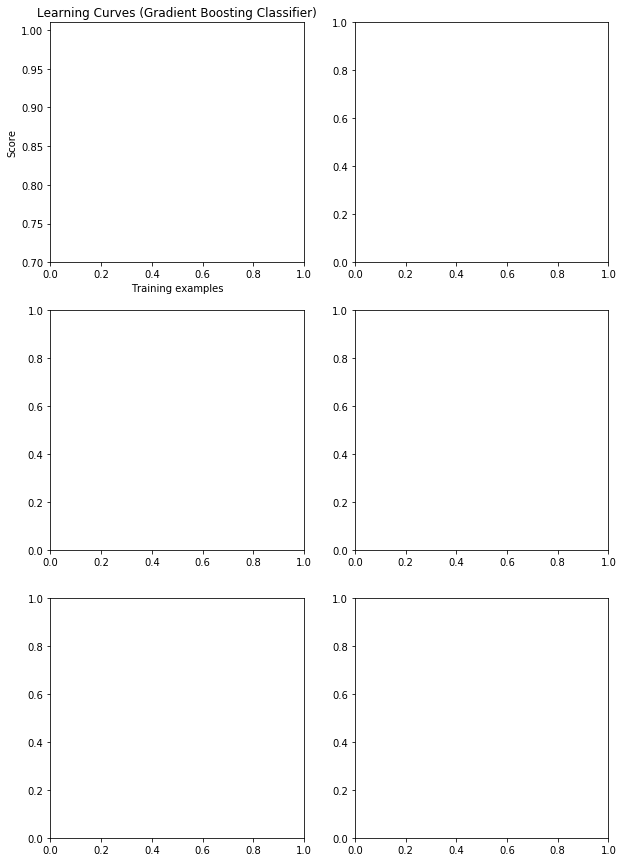

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None,
                        train_sizes=np.concatenate([np.linspace(0.01, 0.1, 4), np.linspace(.1, 1.0, 5)[1:]])):
                        #train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.
    
    Borrowed from: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       # return_times=True)
                       return_times=True, scoring='accuracy') # 'neg_mean_squared_error'
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

start = time.time()
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

title = "Learning Curves (Gradient Boosting Classifier)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = ensemble.GradientBoostingClassifier()
plot_learning_curve(estimator, title, x, y, axes=axes[:, 0], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=-1)

title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, x, y, axes=axes[:, 1], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=-1)

print('plotted learning curves in {:.1}s'.format(time.time() - start))
plt.show()
plt.savefig('plots/learning_curves.pdf')


In [12]:
title = "Learning Curves (Gradient Boosting Classifier)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = ensemble.GradientBoostingClassifier()
train_sizes = np.concatenate([np.linspace(0.01, 0.1, 4), np.linspace(.1, 1.0, 5)[1:]])
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
    estimator,
    x,
    y,
    cv=cv,
    n_jobs=-1,
    train_sizes=train_sizes,
    return_times=True, scoring='accuracy'
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)

In [37]:
start = time.time()

param_grid = [
    {'kernel': ['rbf'],
     'gamma': [1e-3, 1e-4],
     'C': [1, 10, 100, 1000]
    },
    {'kernel': ['linear'],
     'C': [1, 10, 100, 1000]
    }
]

param_grid = {
    'kernel': ['rbf'],
    'C': [1, 10, 100, 1000],
    'gamma': [1e-3, 1e-4, 1e-6, 1e-7, 'auto']
}

clf = GridSearchCV(
    svm.SVC(), param_grid, scoring='accuracy', n_jobs=-1, cv=3
)
clf.fit(transformations.flatten(x), Y)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print(clf.best_score_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

print('tuned parameters in {:.1f}s'.format((time.time() - start)))

NameError: name 'Y' is not defined

In [12]:
all_caller_data = pd.read_hdf(os.path.join(out_dir, 'all_caller_data.hdf'), 'data')

In [14]:
all_caller_data.loc[(all_caller_data['sample'] == 'LIB-03335WT') & (all_caller_data['fusion'] == 'UBE2QL1--GREB1'), ['spanning_reads', 'junction_reads', 'caller', 'foo']]

/cephfs/users/annawoodard/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,spanning_reads,junction_reads,caller,foo
0,1802,25,fusioncatcher,NaN
850,1877,562,starseqr,NaN
1176,2982,1031,mapsplice2,NaN
1342,1877,649,starfusion,NaN
1816,300,526,arriba,NaN
2526,485,1574,pizzly,NaN


In [15]:
i = 0
extra_features = []
for c in all_caller_data.columns:
    if len(all_caller_data[c].unique()) < 50:
        i += 1
        categories = [x for x in all_caller_data[c].unique() if str(x) != 'nan']
        print(c, len(categories), categories)
    else:
        extra_features += [c]
print('found {} encodable columns'.format(i))
print(extra_features)

fusioncatcher_Counts_of_common_mapping_reads 9 [0.0, 1.0, 3.0, 2.0, 5.0, 4.0, 6.0, 7.0, 9.0]
fusioncatcher_Longest_anchor_found 13 [25.0, 19.0, 14.0, 24.0, 16.0, 21.0, 23.0, 22.0, 20.0, 18.0, 17.0, 15.0, 13.0]
fusioncatcher_Fusion_finding_method 5 ['BOWTIE', 'BOWTIE+STAR', 'BOWTIE+BLAT;BOWTIE+STAR', 'BOWTIE+BLAT', 'BOWTIE;BOWTIE+BLAT']
fusioncatcher_Predicted_effect 32 ['out-of-frame', 'in-frame', 'CDS(truncated)/UTR', 'UTR/CDS(truncated)', 'UTR/UTR', 'CDS(truncated)/CDS(no-known-start-or-end)', 'CDS(no-known-start-or-end)/UTR', 'CDS(no-known-start-or-end)/CDS(truncated)', 'CDS(truncated)/exonic(no-known-CDS)', 'CDS(complete)/UTR', 'exonic(no-known-CDS)/UTR', 'UTR/CDS(no-known-start-or-end)', 'CDS(no-known-start-or-end)/exonic(no-known-CDS)', 'exonic(no-known-CDS)/CDS(truncated)', 'CDS(complete)/CDS(no-known-start-or-end)', 'intronic/UTR', 'UTR/exonic(no-known-CDS)', 'CDS(truncated)/---', 'CDS(no-known-start-or-end)/CDS(no-known-start-or-end)', 'UTR/CDS(complete)', 'CDS(no-known-start-

In [55]:
all_caller_data.arriba_fusion_transcript[all_caller_data.arriba_fusion_transcript.notnull()]

1807      GCCTATTTCAAACAG___CAGACCATCCGAGAGCTGTTTGATATGCCCCTGGAGGAACCTTCTAGCTCATCCGTGCCCTCTGCCCCTGAAGAGGAGGAAGAGACTGTGGCCAGCAAGCAGACTCATATTCTGGAGCAG___GCATTGTGTCGGGCAGAAGATGAAGAGGATATCCGTGCAGCCACCCAGGCCAAGGCTGAACAGGTGGCTGAGCTTGCAGAATTTAATGAGAACGATGGGTTTCCTGCTGGTGAGGGAGAGGAAGCTGGCCGGCCTGGGGCTGAGGATGAGGAGATGTCCCGGGCTGAGCAGGAAATTGCTGCCCTCGTAGAACAG|GTGCTGCAAATAGCCAGTTGTCAACCTCCCAACCGAGCCTCAG___CTTCATTACCATCTCAGAAGCAGCAAAGGAGCCAGCAAAAGCTAAGGTACAGAAAGTCGCTTTGGAGGATGATG___GTTTCCGCCTTTTCTTCACATCTGTCCCTGGAGGCCGTGAGAAGGAAGAGTCTCCCCAACCCCGCCGAAAGCGACAGCCCTCCAGCTCCAG___CAGTGAGGACAGTGACGAGGAGTGGCGGCGGTGCCGGGAGGCAGCTGTGTCGGCGTCCGACATCCTACAGGAGTCAGCCATCCACAGCCCTGGAACAGTGGAGAAGGAGGCAAAGAAGAAAAGGAAGTTGAAAAAGAAAGCCAAGAAGGTGGCCAGTGTCGACTCGGCTGTCGCTGCCACCACCCCCACCAGCATGGCCACAGTCCAGAAGCAGAAGTCAGGT                                                             
1808      CAGATTCTGTGGTTATACTCACTCCTCATCCCAAAGAATGAAATTTACCACTCTCCTCTTCTTGGCAGCTGTAGCAGGGGCCCTGGTCTATGCTG___AAGATGCCTCCTCTGACTCGACGGGTGCTGATCCTGCCCAGGA

In [84]:
all_x = pd.read_hdf('/cephfs/users/annawoodard/polyfuse/data/sim_50/processed/assembled_x_all_features.hdf')

correlated_features = set()
correlation_matrix = all_x.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.90:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
correlation_matrix = correlation_matrix.drop(correlated_features)

In [85]:
len(correlated_features)

89

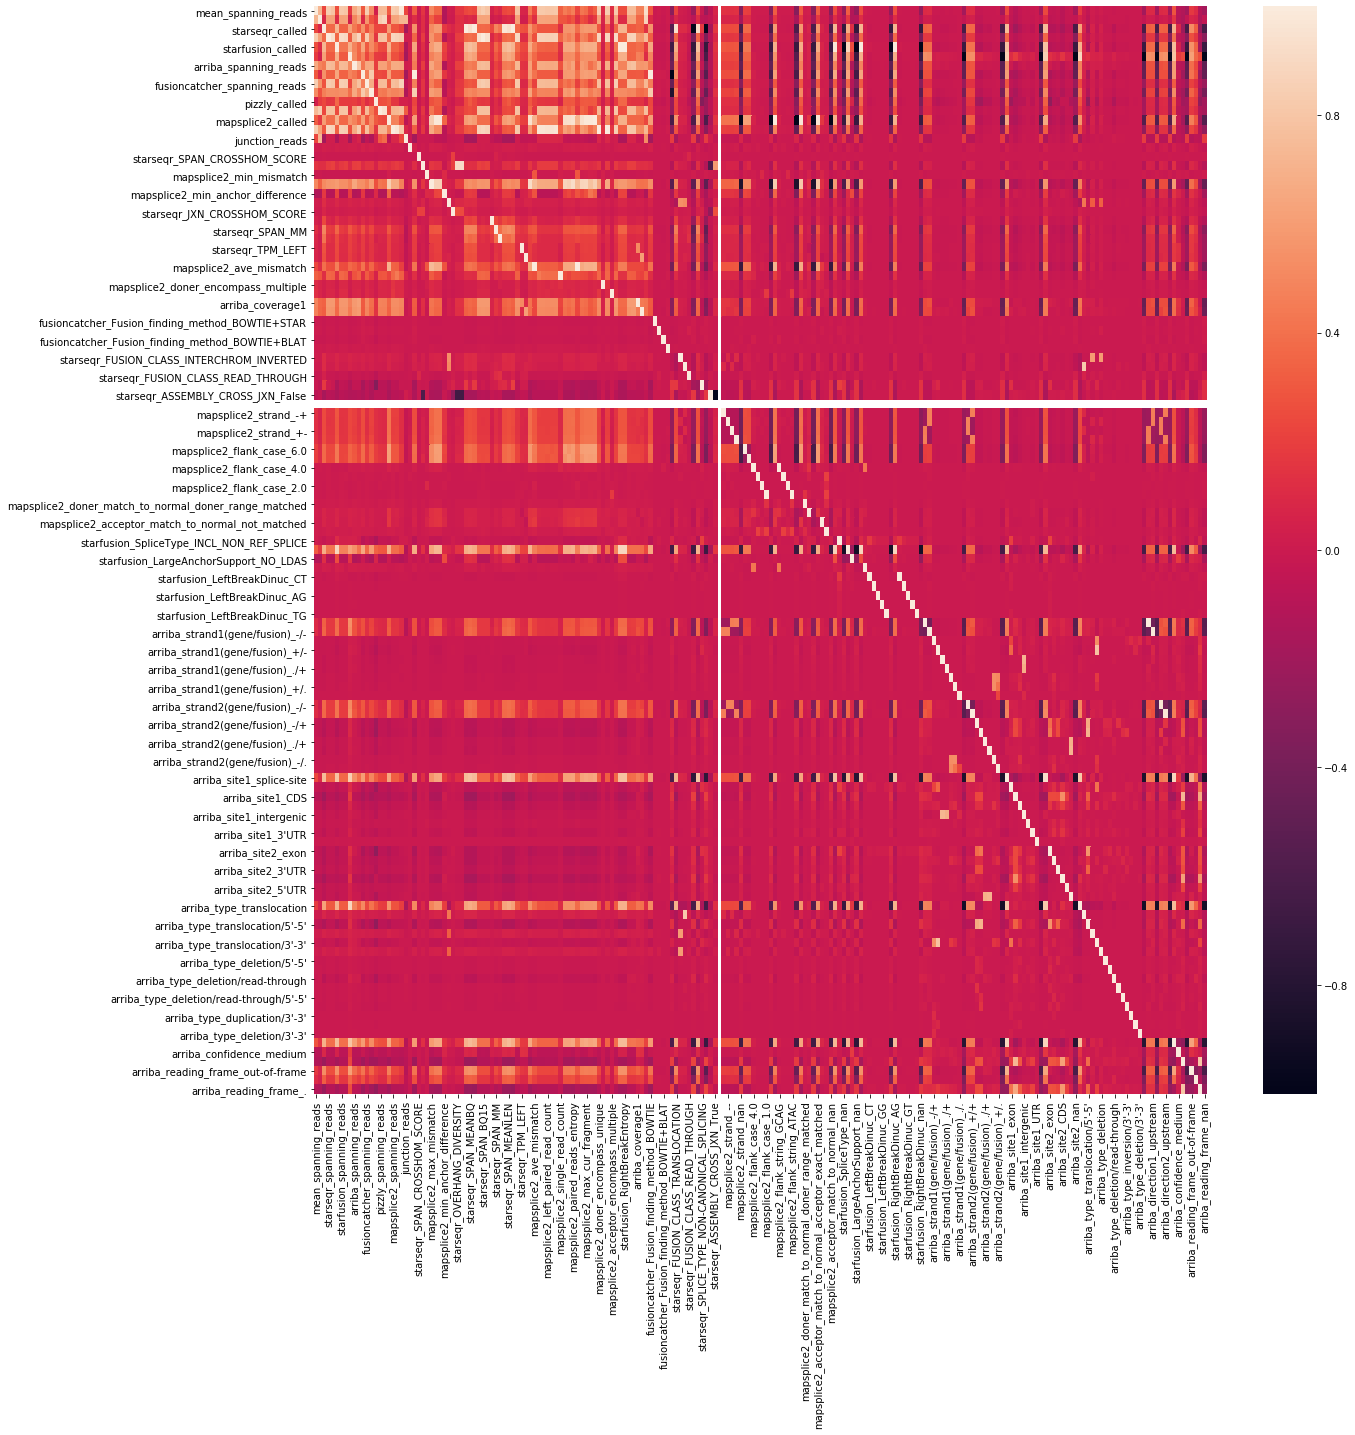

In [86]:
rcParams.update({'figure.autolayout': False})
plt.figure(figsize=(20,20))
#correlation_matrix = correlation_matrix.drop(correlated_features)
sns.heatmap(correlation_matrix)

In [87]:
correlation_matrix.shape

(119, 208)